In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression
from pykrx import stock

# 삼성전자 일별 데이터 가져오기
start_date = "2023-01-01"
end_date = "2025-01-01"
df = stock.get_market_ohlcv_by_date(start_date, end_date, "005930")
df = df[["종가"]].copy()
df["수익률"] = df["종가"].pct_change()
df.dropna(inplace=True)

# 수익률 기반 MSDR 모델
returns = df["수익률"]
model = MarkovRegression(returns, k_regimes=2, trend="c", switching_variance=True)
result = model.fit()

# 시각화: 수익률 + 체제 색상
smoothed_probs = result.smoothed_marginal_probabilities
dates = returns.index


# 결과 요약
print(result.summary())


                        Markov Switching Model Results                        
Dep. Variable:                    수익률   No. Observations:                  488
Model:               MarkovRegression   Log Likelihood                1317.611
Date:                Tue, 27 May 2025   AIC                          -2623.222
Time:                        08:35:49   BIC                          -2598.080
Sample:                             0   HQIC                         -2613.346
                                - 488                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.001     -0.575      0.565      -0.002       0.001
sigma2         0.0002   4.63e-05      3.916      0.0

/home/restful3/anaconda3/envs/ml4t/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


### ✅ Regime 0 (체제 0)

* `const`: -0.0005 → 수익률이 거의 0에 가까움
* `sigma2`: **0.0002** → **낮은 변동성**, 통계적으로 유의함 (`p < 0.001`)

### ✅ Regime 1 (체제 1)

* `const`: 0.0036 → 체제 0에 비해 수익률이 약간 양수
* `sigma2`: **0.0009** → **높은 변동성**, 유의수준 경계선(`p = 0.05`)

### 🔍 해석:

* **Regime 0**은 **저변동성 상태** (안정기), 수익률이 미미하고 안정적인 기간을 설명
* **Regime 1**은 **고변동성 상태** (불안정기), 변동성이 크고 수익률이 더 분산됨

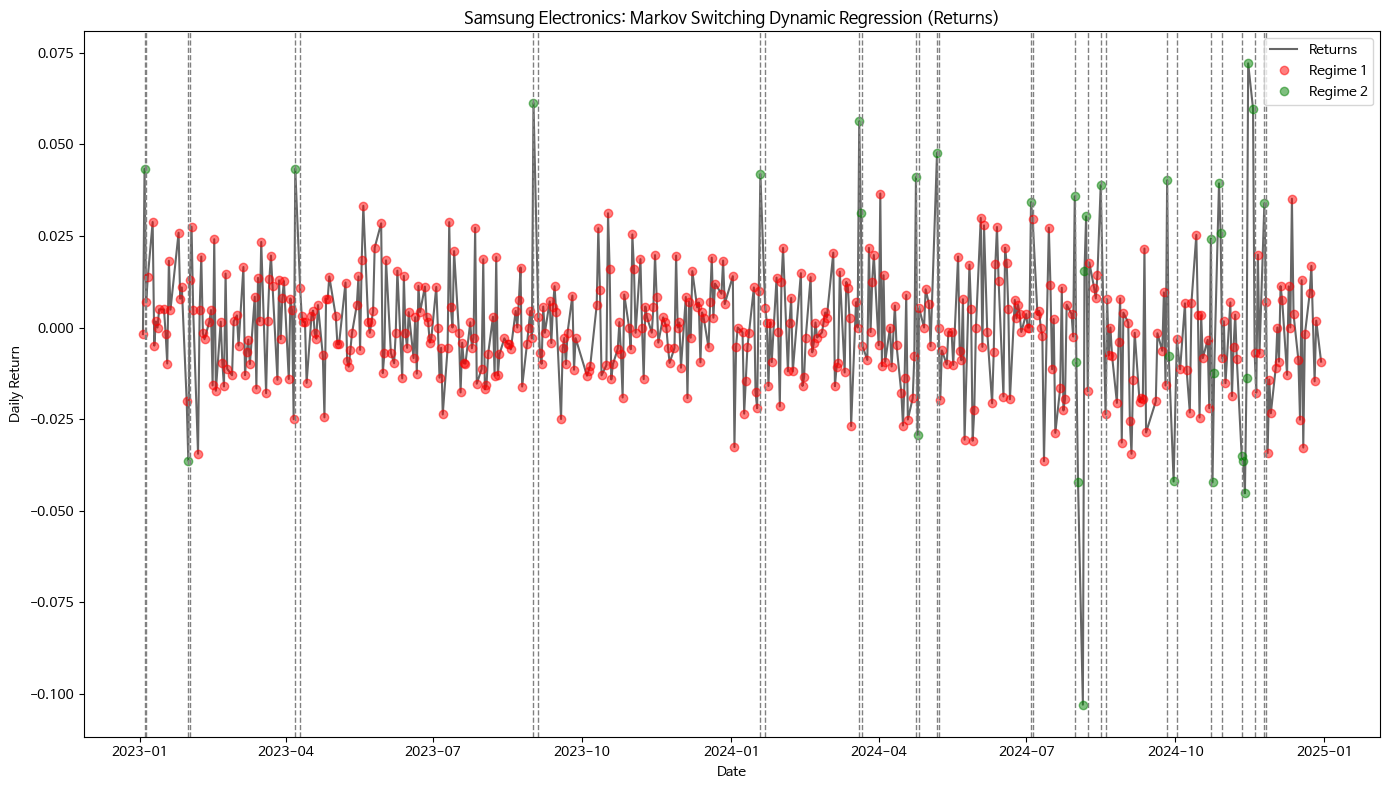

In [9]:
plt.figure(figsize=(14, 8))
plt.plot(dates, returns, label="Observed Returns", color="black", alpha=0.6)
for t in range(len(smoothed_probs)):
    if smoothed_probs.iloc[t, 0] > 0.5:
        plt.plot(dates[t], returns.iloc[t], "ro", alpha=0.5)
    else:
        plt.plot(dates[t], returns.iloc[t], "go", alpha=0.5)

regime_changes = np.argmax(smoothed_probs.values, axis=1)
for i in range(1, len(regime_changes)):
    if regime_changes[i] != regime_changes[i - 1]:
        plt.axvline(x=dates[i], color="gray", linestyle="--", linewidth=1)

plt.title("Samsung Electronics: Markov Switching Dynamic Regression (Returns)")
plt.xlabel("Date")
plt.ylabel("Daily Return")
plt.legend(["Returns", "Regime 1", "Regime 2"])
plt.tight_layout()
plt.show()

## 📈 2. **수익률 + 체제 시각화**

### 🔍 해석:

* 그래프에서 **빨간 점**은 **Regime 1 (고변동성)**, **초록 점**은 **Regime 0 (저변동성)** 으로 분류됨
* 빨간색 체제가 대부분을 차지하고 있으나, 중간중간 초록색(안정기)이 반복적으로 나타남
* **회색 점선**은 **체제 전환 시점**으로, 체제가 자주 전환됨 → **빈번한 구조 변화**


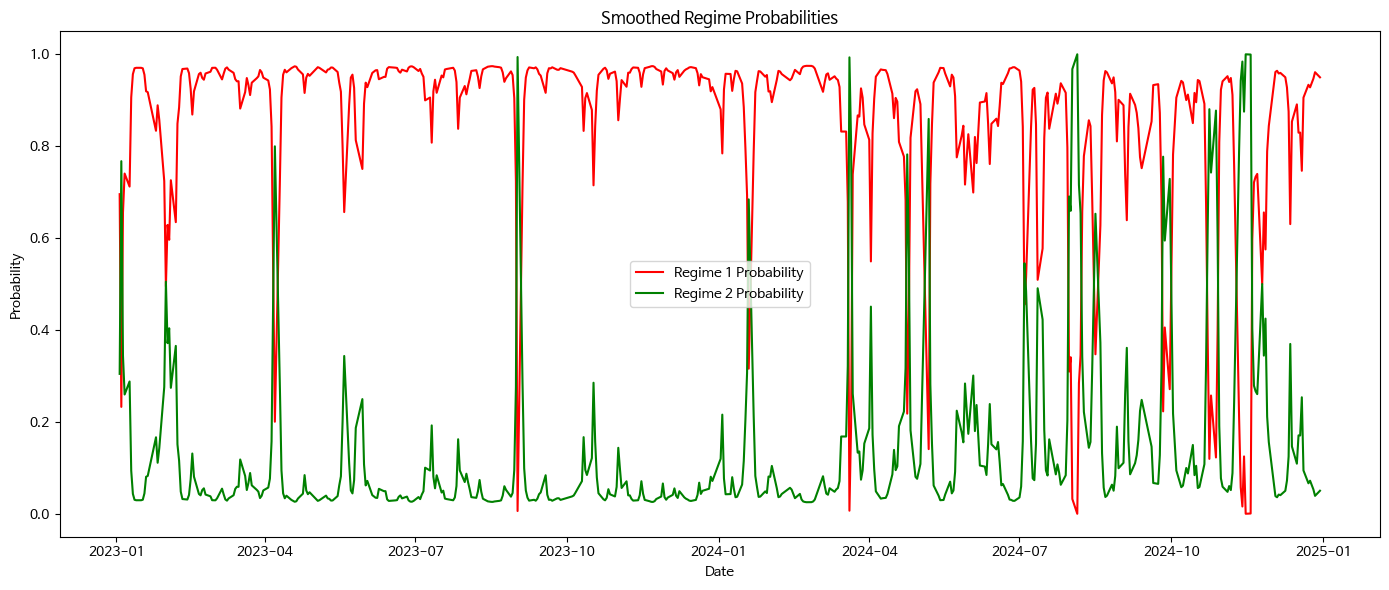

In [10]:
# 체제 확률 시각화
plt.figure(figsize=(14, 6))
plt.plot(dates, smoothed_probs[0], label="Regime 1 Probability", color="red")
plt.plot(dates, smoothed_probs[1], label="Regime 2 Probability", color="green")
plt.xlabel("Date")
plt.ylabel("Probability")
plt.title("Smoothed Regime Probabilities")
plt.legend()
plt.tight_layout()
plt.show()



## 🔁 3. **Smoothed Regime Probabilities**

### 🔍 해석:

* **Regime 1 (빨간선)** 의 확률이 대부분 시점에서 **0.9 이상** → 대다수가 고변동 상태로 추정됨
* 일부 기간 (예: 2023년 3월, 2024년 1월, 2024년 10월 등)에서는 **Regime 0 (녹색선)** 이 우세해짐 
* 체제 간 전환이 **짧은 간격으로 빈번하게** 발생 → **변동성이 큰 시장 구조**


## 🔧 4. 분석 요약 및 시사점

| 항목         | 해석                                                        |
| ---------- | --------------------------------------------------------- |
| **주요 체제**  | 대부분 Regime 1 (고변동성)에 있음                                   |
| **체제 전환**  | 잦고 불규칙적이며, 특정 구간에선 명확한 Regime 0 구간 존재                     |
| **투자 시사점** | 변동성이 큰 시기를 식별해 리스크 관리, 현금 비중 조절 등에 활용 가능                  |
| **한계점**    | 수익률 자체의 평균은 두 체제 모두에서 유의하지 않음 → 방향성 보다는 **리스크 상태 구분**에 강점 |
